# Modeling & Inference

### Importing Libraries

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from feature_engine.selection import RecursiveFeatureElimination
from sklearn.model_selection import train_test_split
from feature_engine.encoding import StringSimilarityEncoder
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import ks_2samp
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

### Reading the data

In [2]:
# Read CSVs
real_world_df = pd.read_csv('./data/real-world-data/healthcare-dataset-stroke-data.csv', index_col=0)
train_synthetic_df = pd.read_csv("./data/synthetic-data/train.csv", index_col=0)
test_df = pd.read_csv('./data/synthetic-data/test.csv', index_col=0)

In [3]:
df = pd.concat([train_synthetic_df, real_world_df], ignore_index=True, axis=0)
df.reset_index(drop=True, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [4]:
# Features
s_categorical = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
binary = ["hypertension", "heart_disease"] # Basically, categorical values with only 2 values. 1 or 0
continous_numerical = ["age", "avg_glucose_level", "bmi"]

### Baseline

In [5]:
@ignore_warnings(category=ConvergenceWarning)
def baseline(train_df, cv, oof_preds, target, train_auc, val_auc, pipelines, model, encoder, scaler):
    # cast categorical features as categorical type
    train_df[s_categorical] = (train_df[s_categorical].astype("category"))
    for fold, (train_indx, val_indx) in enumerate(cv.split(train_df, target)):
        X_train, Y_train = train_df.iloc[train_indx], target.iloc[train_indx]
        X_val, Y_val = train_df.iloc[val_indx], target.iloc[val_indx]
        
        X_train = X_train.copy()
        X_val = X_val.copy()
        


        X_train = encoder.fit_transform(X_train)
        X_train = scaler.fit_transform(X_train)
        
        X_val = encoder.transform(X_val)
        X_val = scaler.transform(X_val)

        print("_"*50)
        
        model.fit(X_train, Y_train)
        
        oof_preds.iloc[val_indx] = model.predict_proba(X_val)[:, 1]
        train_auc.append(roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1]))
        val_auc.append(roc_auc_score(Y_val, model.predict_proba(X_val)[:, 1]))
        pipelines.append([encoder, scaler, model])

        print(f"Val AUC: {val_auc[-1]}")
    return pipelines, train_auc, val_auc, oof_preds

Pipeline with Logistic Regression + OneHot Encoder

In [6]:
cv = StratifiedKFold(shuffle=True, random_state=42)
features = s_categorical + continous_numerical
model = LogisticRegression()
encoder = OneHotEncoder(drop_last=True, variables=s_categorical)
scaler = SklearnTransformerWrapper(StandardScaler(), variables=continous_numerical)

In [7]:
train_auc = []
val_auc = []
pipelines = []
oof_preds = pd.Series(0, index=train_synthetic_df.index)

train_df = train_synthetic_df[features].copy()
target = train_synthetic_df["stroke"]

_, train_auc, val_auc, oof_preds_synth = baseline(train_df, cv, oof_preds, target, train_auc, val_auc, pipelines, model, encoder, scaler)
print()
print(f"Synthetic Train AUC: {np.mean(train_auc)}")
print(f"Synthetic Val AUC: {np.mean(val_auc)}")
print(f"Synthetic OOF AUC score: {roc_auc_score(target, oof_preds_synth)}")

__________________________________________________
Val AUC: 0.882504529352911
__________________________________________________
Val AUC: 0.8824828966225899
__________________________________________________
Val AUC: 0.8923830840163384
__________________________________________________
Val AUC: 0.8760177983886983
__________________________________________________
Val AUC: 0.8797080750045986

Synthetic Train AUC: 0.8849088476136592
Synthetic Val AUC: 0.8826192766770273
Synthetic OOF AUC score: 0.8824682638419171


Let's try other encoders.

In [8]:
encoder = CountFrequencyEncoder(variables=s_categorical)
train_auc = []
val_auc = []
pipelines = []
oof_preds = pd.Series(0, index=train_synthetic_df.index)
target = train_synthetic_df["stroke"]
pipelines, train_auc, val_auc, oof_preds_f = baseline(train_df, cv, oof_preds, target, train_auc, val_auc, pipelines, model, encoder, scaler)
print()
print(f"Synthetic CountFrequencyEncoder Train AUC: {np.mean(train_auc)}")
print(f"Synthetic CountFrequencyEncoder Val AUC: {np.mean(val_auc)}")
print(f"Synthetic CountFrequencyEncoder OOF AUC: {roc_auc_score(target, oof_preds_f)}")

__________________________________________________
Val AUC: 0.8828614694032071
__________________________________________________
Val AUC: 0.8822422324977691
__________________________________________________
Val AUC: 0.8924340745750339
__________________________________________________
Val AUC: 0.8686778416501618
__________________________________________________
Val AUC: 0.875850726566473

Synthetic CountFrequencyEncoder Train AUC: 0.8817984049890443
Synthetic CountFrequencyEncoder Val AUC: 0.8804132689385291
Synthetic CountFrequencyEncoder OOF AUC: 0.8802621112460831


In [9]:
encoder = StringSimilarityEncoder(variables=s_categorical)
train_auc = []
val_auc = []
pipelines = []
oof_preds = pd.Series(0, index=train_synthetic_df.index)
target = train_synthetic_df["stroke"]
pipelines, train_auc, val_auc, oof_preds_ss = baseline(train_df, cv, oof_preds, target, train_auc, val_auc, pipelines, model, encoder, scaler)
print()
print(f"Synthetic StringSimilarityEncoder Train AUC: {np.mean(train_auc)}")
print(f"StringSimilarityEncoder Val AUC: {np.mean(val_auc)}")
print(f"StringSimilarityEncoder OOF AUC score: {roc_auc_score(target, oof_preds_ss)}")

__________________________________________________
Val AUC: 0.8825829480003246
__________________________________________________
Val AUC: 0.8824801925312998
__________________________________________________
Val AUC: 0.8924743302792673
__________________________________________________
Val AUC: 0.8759990123933894
__________________________________________________
Val AUC: 0.8797432401726881

Synthetic StringSimilarityEncoder Train AUC: 0.8849180160213044
StringSimilarityEncoder Val AUC: 0.8826559446753939
StringSimilarityEncoder OOF AUC score: 0.8825379306834338


It seems that StringSimilarityEncoder gives the highest score but its method doesn't make much sense to us. Our best choice for encoders is OneHotEncoder.   
We will try a submission with StringSimilarityEncoder as well.

In [10]:
oof_preds_ss.rename('stroke', inplace=True)
oof_preds_ss.to_csv('./submissions/submission_oof.csv')  # Public Score: 0.86705

>The Kolmogorov–Smirnov test is a nonparametric goodness-of-fit test and is used to determine wether two distributions differ, or whether an underlying probability distribution differes from a hypothesized distribution. It is used when we have two samples coming from two populations that can be different.  

>If the p-value is lower than our threshold of 0.05, so we reject the null hypothesis in favor of the default “two-sided” alternative: the data were not drawn from the same distribution.

In [11]:
ks_2samp(oof_preds_synth[target==0], oof_preds_synth[target==1])

KstestResult(statistic=0.6091470190356556, pvalue=2.4700771372158504e-216, statistic_location=0.0410081412417565, statistic_sign=1)

### Trying RecursiveFeatureElimination

In [12]:
# initialize linear regresion estimator
X = train_synthetic_df.drop("stroke", axis=1)
y = train_synthetic_df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
linear_model = LinearRegression()

# initialize feature selector
tr = RecursiveFeatureElimination(estimator=linear_model, scoring="r2", cv=3)
Xt = tr.fit_transform(X_train, y_train)
print(tr.initial_model_performance_)
print(tr.performance_drifts_)
print(tr.features_to_drop_)
del X, y, X_train, X_test, y_train, y_test, linear_model, tr, Xt

0.0900333374972037
{'avg_glucose_level': 0.0114814154900168, 'bmi': 0.002188074390195749, 'age': 0.04421995300609483, 'heart_disease': 0.000671441535687517, 'hypertension': 0.006686764700367692}
['hypertension', 'heart_disease', 'bmi']


### Feature Engineering

In [13]:
# This is based off of information from Kaggle
def generate_features(df):
    df['age/bmi'] = df.age / df.bmi
    df['age*bmi'] = df.age * df.bmi
    df['bmi/prime'] = df.bmi / 25
    df['obesity'] = df.avg_glucose_level * df.bmi / 1000
    df['blood_heart']= df.hypertension*df.heart_disease
    return df

In [14]:
categorical = s_categorical + binary
features = categorical + continous_numerical + ['age/bmi', 'age*bmi', 'bmi/prime', 'obesity', 'blood_heart']
rfe_features =[
    'age', 'avg_glucose_level', 'bmi', 'ever_married_Yes', 'gender_Male',
    'hypertension_0', 'smoking_status_Unknown', 'smoking_status_formerly smoked',
    'smoking_status_never smoked', 'work_type_Self-employed', 'work_type_children'
]



### Final Submission Experiments

In [15]:
real_world_df = pd.read_csv('./data/real-world-data/healthcare-dataset-stroke-data.csv',)

train_df = pd.read_csv('./data/synthetic-data/train.csv', index_col=0)
test_df = pd.read_csv('./data/synthetic-data/test.csv', index_col=0)



In [16]:
def XGBoost_model(synthetic_train_df, real_world_df, train_df, test_df_c, real_world_target, encoder):
    # cast categorical features as categorical type
    synthetic_train_df[categorical] = (synthetic_train_df[categorical].astype('category'))
    real_world_df[categorical] = (real_world_df[categorical].astype('category'))


    target = train_df['stroke']
    # Grab Target
    oof_preds = pd.Series(0, index=train_df.index, name='stroke')
    test_preds = pd.Series(0, index=test_df.index, name='stroke')

    train_auc, val_auc = [], []
    pipelines = []

    for fold, (train_indx, val_indx) in enumerate(cv.split(train_df, target)):
        pipeline = []
        X_train, y_train = synthetic_train_df.iloc[train_indx], target.iloc[train_indx]
        X_val, y_val = synthetic_train_df.iloc[val_indx], target.iloc[val_indx]
        X_test = test_df_c.copy()

        # concat prev dataset
        X_train = pd.concat([X_train, real_world_df], axis=0)
        y_train = pd.concat([y_train, real_world_target])

        X_train = X_train.copy()
        X_val = X_val.copy()


        model = XGBClassifier(
            random_state=42, learning_rate=1e-2,
            n_estimators=3000,
            tree_method='gpu_hist',
            callbacks=[
                EarlyStopping(100, save_best=True, maximize=False),
            ]
        )

        # Fit encoder
        X_train = encoder.fit_transform(X_train)
        X_val = encoder.transform(X_val)
        X_test = encoder.transform(X_test)
        pipeline.append(encoder)

        # filter columns by RFE columns
        X_train = X_train[X_train.columns.intersection(rfe_features)]
        X_val = X_val[X_val.columns.intersection(rfe_features)]
        X_test = X_test[X_test.columns.intersection(rfe_features)]

        print('_'*50)

        model.fit(
            X_train, y_train,
            eval_set=[(X_val,y_val)],
            verbose=1000,
        )

        oof_preds.iloc[val_indx] = model.predict_proba(X_val)[:, 1]
        test_preds += model.predict_proba(X_test)[:, 1]

        train_auc.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
        val_auc.append(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))

        pipeline.append(model)
        pipelines.append(pipeline)

        print(f'Val AUC: {val_auc[-1]}')

    print()
    print(f'Mean Val AUC: {np.mean(val_auc)}')
    print(f'OOF AUC: {roc_auc_score(target, oof_preds)}')
    return test_preds, pipelines, train_auc, val_auc

In [17]:
def impute_mean(real_world_df):
    mean_imputer = SimpleImputer(strategy="mean")
    real_world_df = real_world_df.copy()
    real_world_df["bmi"] = mean_imputer.fit_transform(real_world_df["bmi"].values.reshape(-1,1))
    print("Missing values after imputing with mean: ",sum(real_world_df.isnull().sum()))
    return real_world_df

In [18]:
def impute_dt(real_world_df):    
    DT_bmi_pipe = Pipeline( steps=[ 
                                ("scale",StandardScaler()),
                                ("lr",DecisionTreeRegressor(random_state=42))
                                ])
    real_world_df = real_world_df.copy()
    X = real_world_df[["age","gender","bmi"]].copy()
    X.gender = X.gender.replace({"Male":0,"Female":1,"Other":-1}).astype(np.uint8)

    missing = X[X.bmi.isna()]
    X = X[~X.bmi.isna()]
    Y = X.pop("bmi")
    DT_bmi_pipe.fit(X,Y)
    predicted_bmi = pd.Series(DT_bmi_pipe.predict(missing[["age","gender"]]),index=missing.index)
    real_world_df.loc[missing.index,"bmi"] = predicted_bmi

    print("Missing values after decision tree regressor: ",sum(real_world_df.isnull().sum()))
    return real_world_df

In [19]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Generate feature engineering
synthetic_train_df = generate_features(train_df.copy())
test_df_c = generate_features(test_df.copy())
real_world_df_dt = impute_dt(real_world_df)
real_world_df_mean = impute_mean(real_world_df)
real_world_df_dt = generate_features(real_world_df_dt.copy())
real_world_df_mean = generate_features(real_world_df_mean.copy())
replace_unknows_rw = real_world_df_mean.copy()
replace_unknown_s = synthetic_train_df.copy()
replace_unknows_rw["smoking_status"] = replace_unknows_rw["smoking_status"].replace("Unknown", "never smoked")
replace_unknown_s["smoking_status"] = replace_unknown_s["smoking_status"].replace("Unknown", "never smoked")

real_world_target = real_world_df["stroke"]

# filter features 
synthetic_train_df = synthetic_train_df[features]
test_df_c = test_df_c[features]
real_world_df_dt = real_world_df_dt[features]
real_world_df_mean = real_world_df_mean[features]
replace_unknows_rw = replace_unknows_rw[features]
replace_unknown_s = replace_unknown_s[features]


Missing values after decision tree regressor:  0
Missing values after imputing with mean:  0


In [20]:
preds_ss_mean, pipelines, train_auc, val_auc = XGBoost_model(synthetic_train_df, real_world_df_mean, train_df, test_df_c, real_world_target, encoder=StringSimilarityEncoder(variables=categorical))
preds_ss_mean /= len(pipelines)

__________________________________________________
[0]	validation_0-logloss:0.68453
[930]	validation_0-logloss:0.12712
Val AUC: 0.8864452229574844
__________________________________________________
[0]	validation_0-logloss:0.68455
[645]	validation_0-logloss:0.12764
Val AUC: 0.8772976947363869
__________________________________________________
[0]	validation_0-logloss:0.68448
[583]	validation_0-logloss:0.12509
Val AUC: 0.8803521216768916
__________________________________________________
[0]	validation_0-logloss:0.68457
[775]	validation_0-logloss:0.12507
Val AUC: 0.8954925017041582
__________________________________________________
[0]	validation_0-logloss:0.68453
[756]	validation_0-logloss:0.12277
Val AUC: 0.8922322848703216
__________________________________________________
[0]	validation_0-logloss:0.68454
[650]	validation_0-logloss:0.12744
Val AUC: 0.8863569967864446
__________________________________________________
[0]	validation_0-logloss:0.68453
[704]	validation_0-logloss:0.12507

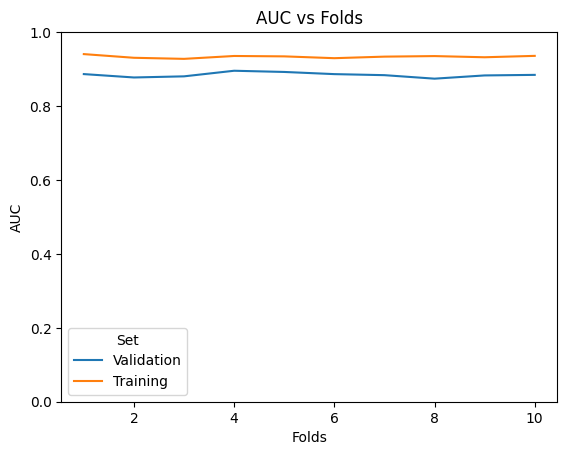

In [21]:
# Generate a list of epochs based on the length of val_auc/train_auc
epochs = list(range(1, len(val_auc) + 1))

# Create a DataFrame with the values and corresponding labels
data = {'AUC': val_auc + train_auc,
        'Set': ['Validation'] * len(val_auc) + ['Training'] * len(train_auc),
        'Epoch': epochs + epochs}
plot_df = pd.DataFrame(data)

# Plot using seaborn
sns.lineplot(data=plot_df, x='Epoch', y='AUC', hue='Set')

# Add labels and title
plt.xlabel('Folds')
plt.ylabel('AUC')
plt.title('AUC vs Folds')

# Set y-axis limits to range from 0 to 1
plt.ylim(0, 1)

# Save plot
plt.savefig("auc_folds_plot.png")
# Show the plot
plt.show()

Our apprach does seem to be doing well. It performs well in Public Leaderboard and performs to our expectations

In [22]:
preds_ss_dt, pipelines, _, _ = XGBoost_model(synthetic_train_df, real_world_df_dt, train_df, test_df_c, real_world_target, encoder=StringSimilarityEncoder(variables=categorical))
preds_ss_dt /= len(pipelines)

__________________________________________________
[0]	validation_0-logloss:0.68453
[817]	validation_0-logloss:0.12563
Val AUC: 0.8865317244063837
__________________________________________________
[0]	validation_0-logloss:0.68455
[820]	validation_0-logloss:0.12775
Val AUC: 0.877459884953073
__________________________________________________
[0]	validation_0-logloss:0.68448
[579]	validation_0-logloss:0.12528
Val AUC: 0.878328433878664
__________________________________________________
[0]	validation_0-logloss:0.68457
[767]	validation_0-logloss:0.12569
Val AUC: 0.8947043285616906
__________________________________________________
[0]	validation_0-logloss:0.68453
[851]	validation_0-logloss:0.12454
Val AUC: 0.8900033542160333
__________________________________________________
[0]	validation_0-logloss:0.68455
[640]	validation_0-logloss:0.12758
Val AUC: 0.8856536934246546
__________________________________________________
[0]	validation_0-logloss:0.68453
[713]	validation_0-logloss:0.12466
V

In [23]:
preds_ss_dt.rename('stroke', inplace=True)
preds_ss_dt.to_csv('./submissions/submission_ss_dt.csv') # Public Score: 0.8658
preds_ss_mean.rename('stroke', inplace=True)
preds_ss_mean.to_csv('submissions/submission_ss_mean.csv')  # Public Score: 0.8672

We see that imputing with mean fits better to our model.    
Lets try impting with mean and using OneHotEncoding

In [24]:
preds_oh, pipelines, _, _ = XGBoost_model(synthetic_train_df, real_world_df_mean, train_df, test_df_c, real_world_target, encoder=OneHotEncoder(variables=categorical))
preds_oh /= len(pipelines)

__________________________________________________
[0]	validation_0-logloss:0.68455
[804]	validation_0-logloss:0.12690
Val AUC: 0.8832230439859867
__________________________________________________
[0]	validation_0-logloss:0.68454
[877]	validation_0-logloss:0.12842
Val AUC: 0.8747783400371956
__________________________________________________
[0]	validation_0-logloss:0.68449
[576]	validation_0-logloss:0.12493
Val AUC: 0.8806396983640081
__________________________________________________
[0]	validation_0-logloss:0.68457
[710]	validation_0-logloss:0.12429
Val AUC: 0.8992309986366734
__________________________________________________
[0]	validation_0-logloss:0.68454
[755]	validation_0-logloss:0.12264
Val AUC: 0.8949589379037233
__________________________________________________
[0]	validation_0-logloss:0.68455
[644]	validation_0-logloss:0.12700
Val AUC: 0.8885967474924531
__________________________________________________
[0]	validation_0-logloss:0.68453
[705]	validation_0-logloss:0.12474

As we saw in our LogisticRegressor, StringSimilarityEncoder fits *very slightly* better than OneHotEncoder.

In [25]:
preds_oh.rename('stroke', inplace=True)
preds_oh.to_csv('./submissions/submission_oh.csv')  # Public Score: 0.86705

Let's try replacing the "Unknown"s in `smoking_status` by "never smoked" as we discussed in the EDA.

In [26]:
preds_unkw, pipelines, _, _ = XGBoost_model(replace_unknown_s, replace_unknows_rw, train_df, test_df_c, real_world_target, encoder=StringSimilarityEncoder(variables=categorical))
preds_unkw /= len(pipelines)

__________________________________________________
[0]	validation_0-logloss:0.68453
[778]	validation_0-logloss:0.12594
Val AUC: 0.8880076553782276
__________________________________________________
[0]	validation_0-logloss:0.68453
[811]	validation_0-logloss:0.12862
Val AUC: 0.8748215907616452
__________________________________________________
[0]	validation_0-logloss:0.68448
[574]	validation_0-logloss:0.12567
Val AUC: 0.8798781526925699
__________________________________________________
[0]	validation_0-logloss:0.68455
[806]	validation_0-logloss:0.12413
Val AUC: 0.8967120398773005
__________________________________________________
[0]	validation_0-logloss:0.68454
[753]	validation_0-logloss:0.12406
Val AUC: 0.8898194133367957
__________________________________________________
[0]	validation_0-logloss:0.68456
[761]	validation_0-logloss:0.12671
Val AUC: 0.8867627487259389
__________________________________________________
[0]	validation_0-logloss:0.68451
[743]	validation_0-logloss:0.12331

In [27]:
preds_unkw.rename('stroke', inplace=True)
preds_unkw.to_csv('./submissions/submission_unkwn.csv')  # Public Score: 0.86445

We expected that replacing the "Unknown"s in `smoking_status` by "never smoked" since they are close to the attributes of "never smoked" would reduce the noise and result in a better model, however this is not the case. Our final submisson is StringSimilarityEncoder with imputed mean.

Text(0.5, 1.0, 'String Similarity Predictions with Mean Imputed')

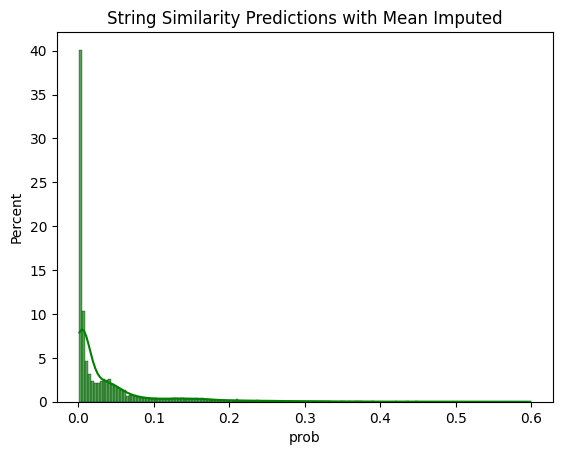

In [28]:
df = preds_ss_mean.to_frame('prob')


ax = sns.histplot(
    data=df, x='prob', common_norm=False,
    stat='percent', color="green", alpha=0.7,
    kde=True
)

ax.set_title('String Similarity Predictions with Mean Imputed')